<a href="https://colab.research.google.com/github/vgorbikov/infotransfer_labs/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание

Для соответствующих сигналов $U$ и матриц смешения $A$ из вариантов [лабораторной работы №3](https://colab.research.google.com/drive/1eIm3dXy-OhzgnGu1vSuSWR0QbrQXEYly?usp=sharing) воспроизвести алгоритм слепого разделения источников одним из приведенных способов:
- Анализ независимых компонентов, С. Хайкин «Нейронные сети. Полный курс», второе издание, раздел 10.11.
- Алгоритм FastICA, изложенный в Hyvarinen A., Oja E. «Independent Component Analysis. Algorithms and Applications», раздел 6. Учесть процесс обработки входных данных $X$ (раздел 5) и процесс ортогонализации Грама-Шмидта (раздел 6.2, (44)). В качестве функции активации использовать сигмоиду $\sigma(x)$.

На одном графике построить исходные сигналы $U$ и нормированные восстановленные
реализации $Y$. Сделать соответствующие выводы.

## Вариант 8

$U_0(n) = A \sin(2 \pi n f_0/f_s) + A \cos(2\pi nf_1/f_s + \pi/12)$\
$U_1(n) \sim U(-1;1)$\
$U_2(n) \sim N(0;0.1)$

$$
A = \begin{pmatrix}
-0.907 & -1.521 & 0.36 \\
1.175 & -1.566 & -0.866 \\
1.548 & 1.49 & 1.431
\end{pmatrix}
$$

$$
W = \begin{pmatrix}
-1.396 & 3.888 & 2.688 \\
-0.695 & -0.574 & -0.155 \\
5.984 & -1.414 & 4.614
\end{pmatrix}
$$

где $f_0$ = 3 Гц, $f_1$ = 19 Гц, $f_s$ = 10 кГц, $A$ = 0.1; \
$N(0; 0.1)$ – нормально распределенная случайная
величина с $m$ = 0 и $\sigma$ = 0.1; \
$U(−1; 1)$ – равномерно распределенная случайная величина в
промежутке $[−1; 1]$

## Теория

> Я буду использовать метод **Infomax**, описанный в *С. Хайкин «Нейронные сети. Полный курс», второе издание, раздел 10.11*

Целью алгоритма является минимизация дивергенции Кльбака-Лейблера между функцией плотности $Y$ и факториальным распределением $Y_i, i=1,2,...,m$. \
Этого можно достичь с помощью метода градиентного спуска, в котором корректируются веса $w_i$ матрицы разделения $W$ (см. [лабораторную работу 3](https://colab.research.google.com/drive/1eIm3dXy-OhzgnGu1vSuSWR0QbrQXEYly?usp=sharing)).

Изменение матрицы $W$ на каждом шаге алгоритма находится по формуле:
$$
\Delta W = \eta [I - \phi(y)y^T]W   
$$

где $y = WX$,\
$\phi(y)$ - функция активации,\
$\eta$ - скорость обучения.

В качестве функции активации обычно используют сигмоиду или гиперболический тангенс. Также, *С. Хайкин* предлагает такую функцию:
$$
\phi(y) = \frac{1}{2}y^5 + \frac{2}{3}y^7 + \frac{15}{2}y^9 + \frac{2}{15}y^{11} - \frac{112}{3}y^{13} + 128y^{15} - \frac{512}{3}y^{17}
$$

### Примечания

- Приведённая выше функция активации, отчего-то, работает только при домножении на $-1$.
- Смешанные сигналы $X$ перед использованием алгоритма необходимо центрировать и сферизовать.
- Для получения стабильного результата важно корректно инициализировать матрицу $W$ перед запуском алгоритма. Веса должны быть распределены равномерно и в небольшом диапазоне значений.
- Во время обучения модели может появиться ошибка, свидетельствующая о переполнении буфера для работы с числами - это происходит из-за того, что функция активации возвращает экстремально высокие значения. Во избежание этого можно нормализовать значения $y$ перед передачей в функцию активации на промежутке $[-1, 1]$. (**Это моя отсебятина, возможно не лучшее решение**)

## Решение

### Описание условий и вспомогательные функции

In [230]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from typing import Callable

# Зафиксируем состояние генератора рандомных чисел
np.random.seed(33)

In [231]:
# Условия задачи
A = np.array(
    [[-0.907, -1.521, 0.36],
    [1.175, -1.566, -0.866],
    [1.548, 1.49, 1.431]])

f_0 = 3000
f_1 = 19000
f_s = 10000
a = 0.1

In [232]:
def U0(n, f_0 = f_0, f_1 = f_1, f_s = f_s, a = a):
  """
  Сигнал 0
  """
  return a*np.sin(2*np.pi*n *f_0/f_s) + a*np.cos(2*np.pi*n*f_1/f_s + np.pi/12)


def U1(count):
  """
  Сигнал 1
  """
  return np.random.uniform(-1.0, 1.0, count)


def U2(count):
  """
  Сигнал 2
  """
  return np.random.normal(0, 0.1, count)

In [233]:
def deviation_index(w: np.array, a: np.array) -> float:
  """
  Рассчёт глобального индекса отклонения
  """
  p = np.dot(w, a)
  n = len(p)
  j = np.sum([np.sum([abs(p[i][j])/np.max(p[i]) for j in range(n)]) - 1 for i in range(n)])
  j += np.sum([np.sum([abs(p[i][j])/np.max([c[j] for c in p]) for i in range(n)]) - 1 for j in range(n)])

  return j




def signal_mixing(A: np.array, signals: tuple[list[float]]) -> np.array:
  """
  Получение смешанных сигналов
  """
  samples_n = len(signals[0])
  signals_count = len(signals)

  XS = np.zeros((samples_n, signals_count))
  us = signals.T

  for n in range(samples_n):
    XS[n] = A@us[n]

  return XS.T



def signal_separation(W: np.array, x_signals: tuple[list[float]]) -> np.array:
  """
  Разделение смешанных сигналов
  """
  # То же самое, только с другими входными данными :)
  return signal_mixing(W, x_signals)

In [234]:
def ampl_deviation(u, y):
  """
  Оценка совпадения формы сигналов
  """
  return min(np.sum(np.abs(u-y)), np.sum(np.abs(u+y)))



def fix_wstrings(us, xs, w):
  """
  Расставить строки в матрице в соответствии с входными сигналами
  Исправить инверсию в амплитудах
  """
  sig_count= len(us)
  for i in range(sig_count):
    best_pair_index = i
    for j in range(sig_count):
      if ampl_deviation(us[i], (w@xs)[j]) < ampl_deviation(us[i], (w@xs)[best_pair_index]):
        best_pair_index = j
    tmp = np.copy(w[i])
    w[i] = np.copy(w[best_pair_index])
    w[best_pair_index] = np.copy(tmp)

  for i in range(len(us)):
    if np.sum(abs(us[i]+(w@xs)[i])) < np.sum(abs(us[i]-(w@xs)[i])):
      w[i] = -1*np.copy(w[i])

In [235]:
# Генерируем отсчёты
steps = np.arange(0, 4, 0.01)

# Вычисляем значения исходных сигналов в точках отсчёта
US = np.zeros((3, len(steps)))

US[0] = [U0(s) for s in steps]
US[1] = U1(len(steps))
US[2] = U2(len(steps))

# Получаем смешанные сигналы
XS = signal_mixing(A, US)

### Реализация алгоритма Infomax

In [236]:
def preprocessing(xs: np.array):
  """
  Предобработка сигналов
  """
  # центрируем
  xs_c = np.array([x - np.mean(x) for x in xs])

  # сферизация
  cov_matrix = np.cov(xs_c)
  eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
  D_sqrt_inv = np.diag(1.0 / np.sqrt(eigenvalues))
  whitening_matrix = np.dot(np.dot(eigenvectors, D_sqrt_inv), eigenvectors.T)
  xs_w = np.dot(whitening_matrix, xs_c)

  return xs_w

In [237]:
def activation_f(y):
  """
  Функция активации, приведённая в книге Хайкина
  """
  return (1/2)*y**5 + (2/3)*y**7 + (15/2)*y**9 + (2/15)*y**11 - (112/3)*y**13 + 128*y**15 - (512/3)*y**17



def train(xs: np.array, w: np.array, speed: float, eps: float = 0.001, activation: Callable[[float], float] = activation_f, max_iteration = 10000000):
  """
  Нахождение матрицы разделения
  """
  # Единичная матрица
  i_matrix = np.eye(w.shape[0])

  iteration_count = 0
  while True:
    dw = np.zeros(w.shape)
    y = np.dot(w, xs)
    y = y/np.max(abs(y))
    dw += speed*np.dot((i_matrix - np.dot(activation(y), y.T)), w)
    w += dw
    iteration_count+=1

    if (np.max(np.abs(dw)) < eps) or iteration_count >= max_iteration:
      break
    elif iteration_count%1000 == 0:
      print(f'Прошло {iteration_count} итераций; dw = {np.max(np.abs(dw))}')

  print(f'Infomax сошёлся за {iteration_count} итераций/и')

In [238]:
# Подготовка сигналов X
xs_processed = preprocessing(XS)

In [239]:
# Инициируем матрицу разделения значениями [0, 0.05]
W = np.random.rand(3, 3)/20

# Находим матрицу разделения
train(xs_processed, W, speed = 0.0002, eps = 1e-06, activation = lambda x: -activation_f(x))
# train(xs_processed, W, speed = 0.001, eps = 1e-06, activation = np.tanh)
# train(xs_processed, W, speed = 0.001, eps = 1e-07, activation = lambda x: 1/(1+np.exp(-x)))

# Переставляем строки в матрице разделения
fix_wstrings(US, xs_processed, W)
# Находим восстановленные сигналы
YS = signal_separation(W, xs_processed)

Infomax сошёлся за 173 итераций/и


Глобальный индекс отклонения: 2.8868180184123506


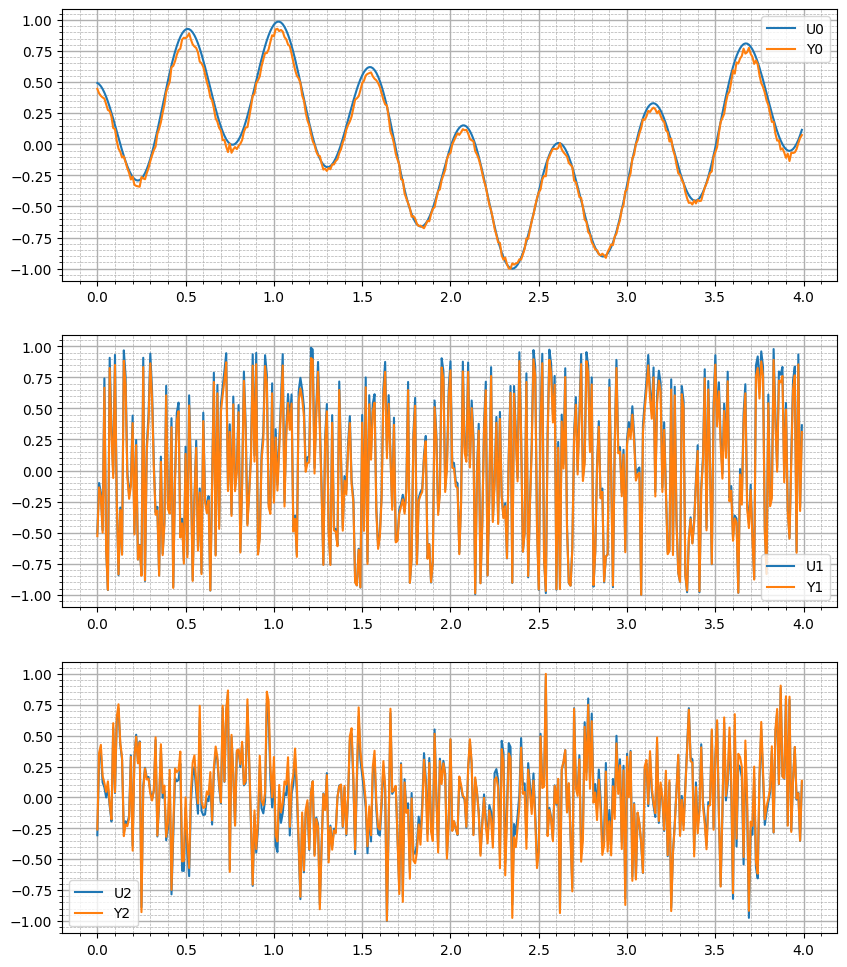

In [240]:
US = np.array([ui/np.max(abs(ui)) for ui in US])
YS = np.array([yi/np.max(abs(yi)) for yi in YS])

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

axs[0].plot(steps, US[0], label='U0')
axs[0].plot(steps, YS[0], label='Y0')

axs[1].plot(steps, US[1], label='U1')
axs[1].plot(steps, YS[1], label='Y1')

axs[2].plot(steps, US[2], label='U2')
axs[2].plot(steps, YS[2], label='Y2')

for ax in axs:
  ax.minorticks_on()
  ax.grid(visible=True, which='major', linewidth=1)
  ax.grid(visible=True, which='minor', linestyle='--', linewidth=0.5)
  ax.legend()

print(f'Глобальный индекс отклонения: {deviation_index(W, A)}')